In [1]:
import torch 
from unet import UNet
from medical_dataset import MedicalDataset
import torch.optim as optim
from loss import Active_Contour_Loss
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [63]:
label = 3
D_train = MedicalDataset(label, "data_train")
D_val = MedicalDataset(label, "data_validation")
D_test = MedicalDataset(label, "data_test")

In [88]:
train_loader = torch.utils.data.DataLoader(
    D_train, batch_size=5, shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    D_val, batch_size=5, shuffle=False
)

In [89]:
model = UNet(1,1)
model.to(device)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [90]:
optimizer = optim.Adam(
    model.parameters(),
    lr=2*10**-6
)

In [91]:
def train(model, optimizer, epoch, loader):
    model.train()
    losses=[]

    for batch_idx, (data, target) in enumerate(loader):
        if device=="cuda":
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = Active_Contour_Loss(output, target)
        #loss = ((output-target)**2).mean()
        #loss = 1 - dice(output, target)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if batch_idx%20==0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(loader.dataset),
                    100.0 * batch_idx / len(loader),
                    loss.data.item(),
                ),
                flush=True,
            )
    return losses

def dice(a,b):
    return 2*(a*b).sum()/(a+b).sum()

def evaluate(model, loader):
    model.eval()
    dice_sum = 0
    dice_ind = 0
    for batch_idx, (data, target) in enumerate(tqdm(loader)):
        if device=="cuda":
            data, target = data.cuda(), target.cuda()
        output = (model(data)>0.5)*1.0
        dice_sum += dice(output, target)
        dice_ind += 1

    return dice_sum/dice_ind

In [85]:
losses= []

In [86]:
evalu = []
for i in range(6):
    losses += train(model, optimizer, i, train_loader)
    evalu.append(evaluate(model, val_loader))
    print(evalu)

Train Epoch: 0 [0/1242 (0%)]	Loss: 0.960778
Train Epoch: 0 [100/1242 (8%)]	Loss: 0.922432
Train Epoch: 0 [200/1242 (16%)]	Loss: 0.936208
Train Epoch: 0 [300/1242 (24%)]	Loss: 0.779404
Train Epoch: 0 [400/1242 (32%)]	Loss: 0.781202
Train Epoch: 0 [500/1242 (40%)]	Loss: 0.654536
Train Epoch: 0 [600/1242 (48%)]	Loss: -0.667930
Train Epoch: 0 [700/1242 (56%)]	Loss: -1.820360
Train Epoch: 0 [800/1242 (64%)]	Loss: 1.359280
Train Epoch: 0 [900/1242 (72%)]	Loss: 6.583427
Train Epoch: 0 [1000/1242 (80%)]	Loss: 2.958090
Train Epoch: 0 [1100/1242 (88%)]	Loss: -3.728919
Train Epoch: 0 [1200/1242 (96%)]	Loss: 2.057874


100%|███████████████████████████████████████████| 56/56 [00:04<00:00, 12.65it/s]


[tensor(0.1103, device='cuda:0')]
Train Epoch: 1 [0/1242 (0%)]	Loss: 1.341521
Train Epoch: 1 [100/1242 (8%)]	Loss: 2.542528
Train Epoch: 1 [200/1242 (16%)]	Loss: 3.278107
Train Epoch: 1 [300/1242 (24%)]	Loss: 2.788935
Train Epoch: 1 [400/1242 (32%)]	Loss: 1.268298
Train Epoch: 1 [500/1242 (40%)]	Loss: 2.100154
Train Epoch: 1 [600/1242 (48%)]	Loss: 1.204512


KeyboardInterrupt: 

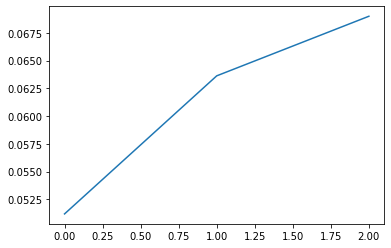

In [70]:
plt.plot(evalu)

In [55]:
max(evalu)

tensor(0.8886, device='cuda:0')

In [57]:
torch.save(model.state_dict(), 'models/unet_L2.pt')

In [77]:
#model.load_state_dict(torch.load('models/unetAC.pt'))

100%|███████████████████████████████████████████| 56/56 [00:04<00:00, 13.32it/s]


tensor(0.7772, device='cuda:0')

In [71]:
x = next(iter(val_loader))

In [72]:
data, target = x[0].cuda(),  x[1].cuda()

In [73]:
model.eval()
out = model(data)>0.5

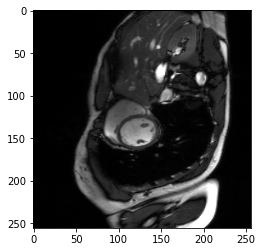

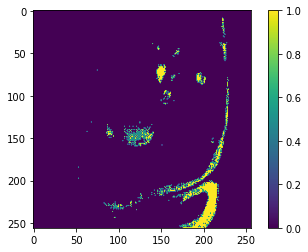

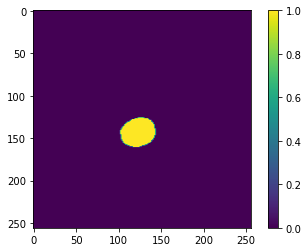

In [87]:
index = 2

plt.imshow(data[index, 0].cpu().detach().numpy(), cmap='gray')
plt.show()

plt.imshow(out[index,0].cpu().detach().numpy())
plt.colorbar()
plt.show()


plt.imshow(target[index,0].cpu().detach().numpy())
plt.colorbar()
plt.show()

In [62]:

def evaluate_rec(model_parse):
    model = UNet(1,1)
    model.to(device)
    for i in range(1,4):
        D_val = MedicalDataset(i, "data_validation")
        val_loader = torch.utils.data.DataLoader(
            D_val, batch_size=5, shuffle=False
        )
        model.load_state_dict(torch.load(model_parse.format(i)))
        model.eval()
        print(evaluate(model, val_loader).item())
        
evaluate_rec('models/unet{}_AC.pt')

100%|███████████████████████████████████████████| 56/56 [00:04<00:00, 13.30it/s]


0.7771750092506409


100%|███████████████████████████████████████████| 56/56 [00:04<00:00, 13.39it/s]


0.8107566237449646


100%|███████████████████████████████████████████| 56/56 [00:04<00:00, 13.34it/s]

0.9015690088272095


In [73]:
from scipy.spatial.distance import directed_hausdorff

In [92]:
u = out[index,0].cpu().detach().numpy()


In [80]:
directed_hausdorff(v,u)

(2.4244442017707892, 156, 247)

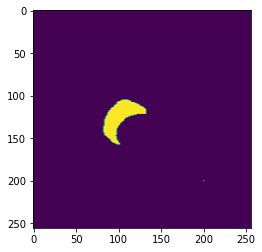

In [83]:
plt.imshow(v)

In [73]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 118.440MB
